In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier

In [2]:
labels = pd.read_csv('marksheet.csv')
dataset = pd.read_csv('PI-CAI_features')

print(dataset.shape)

# Filter the dataset to include only AI annotations and t2w sequences and ROI lesion
filtered_dataset = dataset[dataset['annotator'] == 'AI']
filtered_dataset = filtered_dataset[filtered_dataset['sequence'] == 't2w']
filtered_dataset = filtered_dataset[filtered_dataset['ROI'] == 'lesion']
filtered_dataset.drop(columns=['annotator', 'sequence', 'ROI_ID', 'ROI','img_path', 'seg_path', 'extraction_ID'], inplace=True)
dataset = filtered_dataset

# Rename columns to match the labels dataset
labels.rename(columns={'patient_id': 'patient_ID', 'study_id': 'study_ID'}, inplace=True)

# We only want Magnetic Resonace Biopsy (MRBx) labels because Systematic Biopsy (SBx) labels are not for our usecase
# we also remove those that have both because clicinians result might be biased
#labels = labels[labels['histopath_type'] == 'MRBx']

# Remove useless columns from labels dataset
labels.drop(columns=['mri_date', 'histopath_type', 'center', 'lesion_ISUP', 'lesion_GS'], inplace=True)

# Rename Yes to 1 and No to 0 in the labels dataset
labels.case_csPCa = labels.case_csPCa.map(lambda x: 1 if x == 'YES' else 0)

(6288, 1024)


In [3]:
labels.dropna(inplace=True)

In [4]:
corr_matrix = dataset.drop(columns=['study_ID', 'patient_ID']).corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

dataset.drop(to_drop, axis=1, inplace=True)

In [5]:
isup = 'case_ISUP'
pca = 'case_csPCa'

In [6]:
merge = pd.merge(dataset, labels, on=['patient_ID', 'study_ID'], how='inner')
merge.drop(columns=['patient_ID', 'study_ID'], inplace=True)

In [7]:
merge['ISUP>=3'] = merge[isup].map(lambda x: 1 if x >= 3 else 0)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(merge.drop(columns=[isup, pca, 'ISUP>=3']), merge['ISUP>=3'], test_size=0.2, random_state=42)

## ISUP Prediction

MLP Accuracy: 0.5614035087719298
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.67      0.56        24
           1       0.67      0.48      0.56        33

    accuracy                           0.56        57
   macro avg       0.58      0.58      0.56        57
weighted avg       0.59      0.56      0.56        57



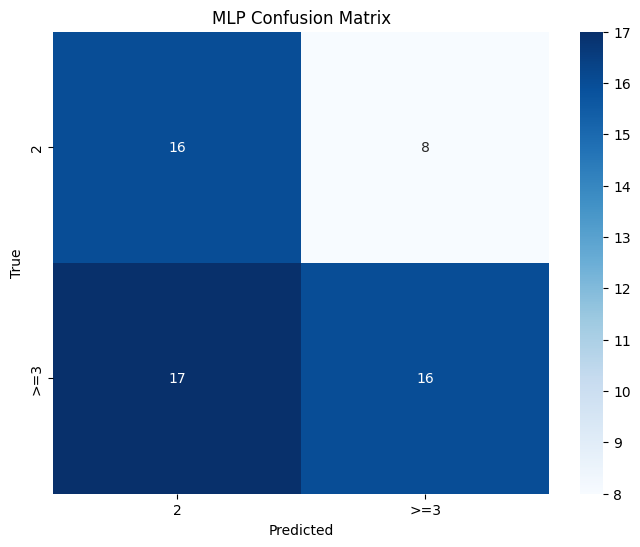

In [9]:
# MLP, my best friend
mlp = MLPClassifier(max_iter=1000, random_state=42, hidden_layer_sizes=(100, 50, 50, 50, 100, 50), activation='relu', solver='adam')
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
mlp_report = classification_report(y_test, y_pred_mlp, output_dict=True)
mlp_cm = confusion_matrix(y_test, y_pred_mlp)

print("MLP Accuracy:", mlp_accuracy)
print("MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['2', '>=3'], yticklabels=['2', '>=3'])
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Random Forest Accuracy: 0.631578947368421
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.88      0.67        24
           1       0.83      0.45      0.59        33

    accuracy                           0.63        57
   macro avg       0.69      0.66      0.63        57
weighted avg       0.71      0.63      0.62        57



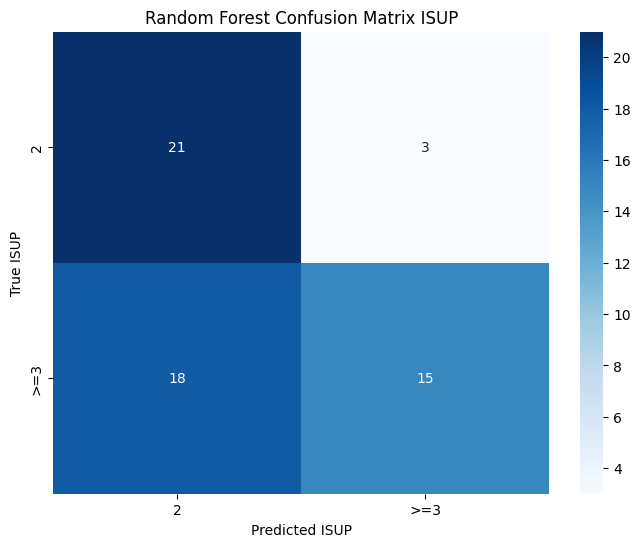

In [10]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
rf_cm = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', yticklabels=['2', '>=3'], xticklabels=['2', '>=3'])
plt.title('Random Forest Confusion Matrix ISUP')
plt.xlabel('Predicted ISUP')
plt.ylabel('True ISUP')
plt.show()


In [11]:
merge[isup].value_counts()

case_ISUP
2    144
3     70
5     40
4     27
Name: count, dtype: int64

In [12]:
pd.Series(y_pred_rf).value_counts()

0    39
1    18
Name: count, dtype: int64

In [13]:
y_test.value_counts()

ISUP>=3
1    33
0    24
Name: count, dtype: int64

## PCa Prediction

In [14]:
# Can we really answer the question?
merge.case_csPCa.unique()

# We can't because we only have positive cases, thus we can't train a model to predict negative cases

array([1])